# Problem 1
## Question
1. 80 points

Infer the ground state energy of $H_2$ for a series of interatomic distances $0.4 < d < 6$ (Bohr) and
plot the ground state energy as function of interatomic distances. (use Qiskit)

## Solution
---

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import qiskit_nature
from qiskit_aer import AerSimulator
from qiskit_algorithms.minimum_eigensolvers import NumPyMinimumEigensolver, VQE
from qiskit_nature.second_q.formats.molecule_info import MoleculeInfo
from qiskit_nature.second_q.mappers import ParityMapper
from qiskit_nature.second_q.circuit.library import UCCSD, HartreeFock
from qiskit_algorithms.optimizers import COBYLA
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.units import DistanceUnit
from qiskit_ibm_runtime import QiskitRuntimeService, Session, EstimatorV1 as Estimator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
qiskit_nature.settings.use_pauli_sum_op = False
with open('../../api_key.txt', 'r') as file:
    token = file.read()
    
service = QiskitRuntimeService(channel='ibm_quantum',token=token)

import warnings
warnings.simplefilter(action='ignore')

ImportError: cannot import name 'EstimatorV1' from 'qiskit_ibm_runtime' (/home/eistee/anaconda3/envs/qiskit_env/lib/python3.12/site-packages/qiskit_ibm_runtime/__init__.py)

In [15]:
# Convert the molecular configuration problem to an observable
def get_qubit_op(dist):
    # Define molecule

    # Your code goes here: 
    molecule = MoleculeInfo(
        symbols=['H','H'],
        coords=([0,0,0],[0,0,dist]),
        multiplicity=1,
        charge=0,
        units=DistanceUnit.BOHR
    )
    
    driver = PySCFDriver.from_molecule(molecule)

    # Get molecule properties
    problem = driver.run()
    num_particles = problem.num_particles
    num_spatial_orbitals = problem.num_spatial_orbitals
    
    mapper = ParityMapper(num_particles=num_particles)
    qubit_op = mapper.map(problem.second_q_ops()[0])
    return qubit_op, num_particles, num_spatial_orbitals, problem, mapper

In [16]:
def exact_solver(qubit_op, problem):
    sol = NumPyMinimumEigensolver().compute_minimum_eigenvalue(qubit_op)
    result = problem.interpret(sol)
    return result

def get_ansatz(num_particles, num_spatial_orbitals, mapper):

    # Define a function that creates the Ansatz as a composition of 
    # a reference state and a variational form circuit: 

    # Your code goes here:
    reference_state=HartreeFock(
        num_spatial_orbitals,
        num_particles,
        mapper
    )

    var_form = UCCSD(
        num_spatial_orbitals=num_spatial_orbitals,
        num_particles=num_particles,
        qubit_mapper=mapper,
        initial_state=reference_state,
    )
    
    return var_form

def quantum_solver(qubit_op,var_form,problem,estimator,optimizer=None):  
    if optimizer == None: 
        optimizer = COBYLA(maxiter=20)
        
    ## Your code goes here ##
    vqe = VQE(estimator=estimator,
              ansatz=var_form,
              optimizer=optimizer,
              initial_point=[0]*var_form.num_parameters)
    
    vqe_calc=vqe.compute_minimum_eigenvalue(operator=qubit_op)
    vqe_result=problem.interpret(vqe_calc).total_energies[0].real


    return vqe_result

In [4]:
real_backend = service.least_busy(operational=True, simulator=False)
sim_backend = AerSimulator.from_backend(real_backend)
sim_backend

AerSimulator('aer_simulator_from(ibm_brisbane)'
             noise_model=<NoiseModel on ['measure', 'ecr', 'id', 'sx', 'reset', 'x']>)

In [5]:
pm_bad = generate_preset_pass_manager(backend=sim_backend, optimization_level=0)
pm_good = generate_preset_pass_manager(backend=sim_backend, optimization_level=3)

In [29]:
exact_energies = []
vqe_energies_noisy = []
vqe_energies_mitigated = []

for dist in np.arange(0.4,6,0.2):
    qubit_op, num_particles, num_spatial_orbitals, problem, mapper = get_qubit_op(dist)

    reference_state = HartreeFock(
        num_spatial_orbitals,
        num_particles,
        mapper
    )

    var_form = UCCSD(
        num_spatial_orbitals=num_spatial_orbitals,
        num_particles=num_particles,
        qubit_mapper=mapper,
        initial_state=reference_state,
        
    )

    # Set up the evaluation of the molecule ground state

    with Session(service=service,backend=sim_backend) as session:
        estimator_noisy = Estimator(session=session, options={"resilience_level": 0})
        estimator_mitigated = Estimator(session=session, options={"resilience_level": 2})
        
        # Prepare problem
        # Your code goes here:
        qubit_op, num_particles, num_spatial_orbitals
        
        # Solve problem exactly
        # Your code goes here:
        result = exact_solver(qubit_op, problem)
        exact_energies.append(result.total_energies[0].real)
        
        # Prepare VQE ansatz
        # Your code goes here:
        var_form = get_ansatz(num_particles, num_spatial_orbitals, mapper)
        
        # Transpile ansatz and operator
        # Your code goes here:
        isa_var_from_good = pm_good.run(var_form)
        isa_qubit_op_good=qubit_op.apply_layout(layout=isa_var_from_good.layout)
        isa_var_from_bad= pm_bad.run(var_form)
        isa_qubit_op_bad=qubit_op.apply_layout(layout=isa_var_from_bad.layout)
        
        # Solve VQE - noisy
        # Your code goes here:
        vqe_result_noisy = quantum_solver(isa_qubit_op_bad,isa_var_from_bad,problem,estimator_noisy)
        vqe_energies_noisy.append(vqe_result_noisy)
        
        # Solve VQE - mitigated (ZNE)
        # Your code goes here:
        vqe_result_mitigated = quantum_solver(isa_qubit_op_good,isa_var_from_good,problem,estimator_mitigated)
        vqe_energies_mitigated.append(vqe_result_mitigated)

        print(
            f"\nInteratomic Distance: {np.round(dist, 2)} (Hartree)\n",
            f"Noisy VQE Result: {vqe_result_noisy:.5f} (Hartree)\n",
            f"Mitigated VQE Result: {vqe_result_mitigated:.5f} (Hartree)\n",
            f"Exact Energy: {exact_energies[-1]:.5f} (Hartree)\n",
        )


Interatomic Distance: 0.4 (Hartree)
 Noisy VQE Result: 0.02897 (Hartree)
 Mitigated VQE Result: 0.02635 (Hartree)
 Exact Energy: 0.02496 (Hartree)


Interatomic Distance: 0.6 (Hartree)
 Noisy VQE Result: -0.67589 (Hartree)
 Mitigated VQE Result: -0.67451 (Hartree)
 Exact Energy: -0.67651 (Hartree)


Interatomic Distance: 0.8 (Hartree)
 Noisy VQE Result: -0.94633 (Hartree)
 Mitigated VQE Result: -0.95437 (Hartree)
 Exact Energy: -0.95760 (Hartree)


Interatomic Distance: 1.0 (Hartree)
 Noisy VQE Result: -1.07839 (Hartree)
 Mitigated VQE Result: -1.08189 (Hartree)
 Exact Energy: -1.07897 (Hartree)


Interatomic Distance: 1.2 (Hartree)
 Noisy VQE Result: -1.12768 (Hartree)
 Mitigated VQE Result: -1.12571 (Hartree)
 Exact Energy: -1.12670 (Hartree)


Interatomic Distance: 1.4 (Hartree)
 Noisy VQE Result: -1.14143 (Hartree)
 Mitigated VQE Result: -1.13564 (Hartree)
 Exact Energy: -1.13728 (Hartree)


Interatomic Distance: 1.6 (Hartree)
 Noisy VQE Result: -1.12994 (Hartree)
 Mitigated VQE R

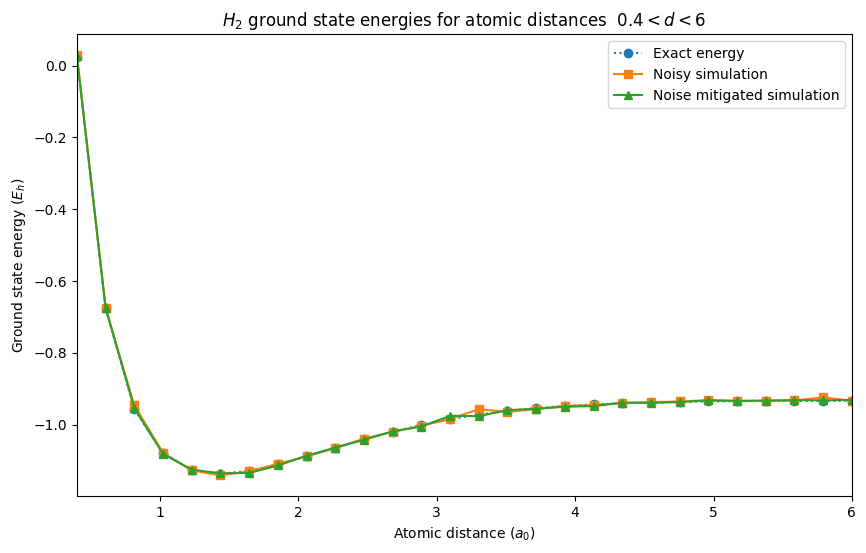

In [30]:
distances = np.linspace(0.4, 6, len(exact_energies))

plt.figure(figsize=(10, 6))
plt.plot(distances, exact_energies, label="Exact energy", marker='o', linestyle=':') 
plt.plot(distances, vqe_energies_noisy, label="Noisy simulation", marker='s')
plt.plot(distances, vqe_energies_mitigated, label="Noise mitigated simulation", marker='^')

plt.xlabel("Atomic distance ($a_{0}$)")
plt.xlim(left=0.4,right=6)
plt.ylabel("Ground state energy ($E_{h}$)")
plt.title("$H_{2}$ ground state energies for atomic distances  $0.4<d<6$")
plt.legend()

plt.show()

# Problem 2
## Question
2. 20 points
   
At what distance is the molecule most stable? (Answere in markdown cell)


Try to execute 1. on a real Quantum Computer. Note that IBM Quantum grants free access to 127 qubit systems for 10 min/month. This might confine the number of steps used in your optimizer.

Hint: Before executin your code check which system is least busy.

## Solution
---
The distance at which the molecule is most stable is at the minimum of the graph which is ~1.4 bohr radii with an energy of -1.14143 Hartree.

I tried to run it on a quantum computer and it just isn't working. It keeps giving the error below which stems from the fact that EstimatorV1 was depracated.

In [17]:
pm_bad = generate_preset_pass_manager(backend=real_backend, optimization_level=0)
pm_good = generate_preset_pass_manager(backend=real_backend, optimization_level=3)

exact_energies = []
vqe_energies_noisy = []
vqe_energies_mitigated = []

with Session(service=service,backend=real_backend) as session:
    for dist in np.arange(0.4,6,5):
        qubit_op, num_particles, num_spatial_orbitals, problem, mapper = get_qubit_op(dist)

        # Set up the evaluation of the molecule ground state
        estimator_noisy = Estimator(session=session, options={"resilience_level": 0})
        estimator_mitigated = Estimator(session=session, options={"resilience_level": 2})
        
        # Prepare problem
        # Your code goes here:
        qubit_op, num_particles, num_spatial_orbitals
        
        # Solve problem exactly
        # Your code goes here:
        result = exact_solver(qubit_op, problem)
        exact_energies.append(result.total_energies[0].real)
        
        # Prepare VQE ansatz
        # Your code goes here:
        var_form = get_ansatz(num_particles, num_spatial_orbitals, mapper)

        
        # Transpile ansatz and operator
        # Your code goes here:
        isa_var_from_good = pm_good.run(var_form)
        isa_qubit_op_good=qubit_op.apply_layout(layout=isa_var_from_good.layout)
        isa_var_from_bad= pm_bad.run(var_form)
        isa_qubit_op_bad=qubit_op.apply_layout(layout=isa_var_from_bad.layout)

        # Solve VQE - noisy
        # Your code goes here:
        vqe_result_noisy = quantum_solver(
            qubit_op=isa_qubit_op_bad,
            var_form=isa_var_from_bad,
            problem=problem,
            estimator=estimator_noisy
            )
        vqe_energies_noisy.append(vqe_result_noisy)
        
        # # Solve VQE - mitigated (ZNE)
        # # Your code goes here:
        vqe_result_mitigated = quantum_solver(qubit_op=isa_qubit_op_good,
                                              var_form=isa_var_from_good,
                                              problem=problem,
                                              estimator=estimator_mitigated)
        vqe_energies_mitigated.append(vqe_result_mitigated)

        print(
            f"\nInteratomic Distance: {np.round(dist, 2)} (Hartree)\n",
            f"Noisy VQE Result: {vqe_result_noisy:.5f} (Hartree)\n",
            f"Mitigated VQE Result: {vqe_result_mitigated:.5f} (Hartree)\n",
            f"Exact Energy: {exact_energies[-1]:.5f} (Hartree)\n",
        )

AlgorithmError: 'The primitive job to evaluate the energy failed!'